# Automate Tool to Create Wordcloud by Album

In [78]:
# turning all of this into one big ol function

# import packages
import spotipy as spt
import sys
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
from datetime import datetime
import re
import requests
import os
import lyricsgenius
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from io import StringIO, BytesIO


def album_wordcloud(uri,boolean,words,scale):
    
    # spotify and genius api tokens
    spotify_client_id = ''
    spotify_client_secret = ''
    genius_access_token = ''
    
    # pulling spotify album data from album uri
    # spotify api credentials login
    client_credentials_manager = SpotifyClientCredentials(spotify_client_id,spotify_client_secret)
    sp = spt.Spotify(client_credentials_manager = client_credentials_manager)
    # album details
    album = sp.album(uri)
    artist = album['artists'][0]['name']
    album_art = album['images'][0]['url']
    
    # creating tracklist of songs in the album
    tracklist = []
    for track in sp.album_tracks(uri)['items']:
        tracklist.append(track['name'])
        
    # pulling genius lyrics for each of the tracks on the album
    # genius api credentials login
    LyricsGenius = lyricsgenius.Genius(
        genius_access_token, verbose = boolean, skip_non_songs = True, timeout = 15
    )
    
    lyriclist = []
    for song in tracklist:
        retries = 0
        while retries < 3:
            try:
                track = LyricsGenius.search_song(song, artist)
            except Timeout as e:
                retries += 1
                continue
        # lyricsgenius has this annoying thing where if a song has no lyrics it returns as None and gives an error later
        # so make sure track has lyrics otherwise pass
        # and also has a bug where sometimes it returns random pieces of text that are not the song
        # so ensure the song title is included in the lyrics (header always is of form 'Song Lyrics')
            if track is not None and song.lower() in track.lyrics.lower():
                lyriclist.append(track.lyrics)
            else:
                pass
            break
    
    # cleaning lyrics
    lyriclines = []
    lyricwords = []
    for song_index in range(len(lyriclist)):
        # removing anything in square brackets like [Chorus]
        lyriclines.append(re.sub(r'\[.*?\]', '',lyriclist[song_index]).replace(artist,''))
        # removing first header 'Song Lyrics'
        for line in lyriclines[song_index].split('Lyrics')[1].split('\n'):
            # 'embed' randomly in there, geniuslyrics bug
            if 'embed' not in line.lower() and artist not in line and 'tickets' not in line.lower() and 'feat' not in line.lower():
                lyricwords.append(line.split())

    # writing lyrics to file
    string = ''
    for line in lyricwords:
        for word in line:
            string += re.sub('[^A-Za-z0-9\']+', '', word.lower())+' '
    file = StringIO(string)
    
    # generating final wordcloud
    # open lyrics file
    text = file.getvalue()
    # import album art from spotipy
    response = requests.get(album_art)
    coloring = np.array(Image.open(BytesIO(response.content)))
    # set words that won't be included in the cloud
    stop_words = ['oh','ohoh'] + list(STOPWORDS)
    # generate word cloud
    wc = WordCloud(background_color="white", max_words=words, relative_scaling=scale, mask=coloring,
               collocations=False,stopwords=stop_words, max_font_size=60, random_state=42,include_numbers=False)
    wc.generate(text)
    # generate image with colors that match its original form
    image_colors = ImageColorGenerator(coloring)
    fig, axes = plt.subplots(1, 2)
    axes[0].set_axis_off()
    axes[0].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    #axes[1].imshow(coloring, cmap=plt.cm.gray, interpolation="bilinear")
    # show final plot
    # for ax in axes:
    # ax.set_axis_off()
    print(album['name'],'by',artist)
    plt.show()

My Beautiful Dark Twisted Fantasy by Kanye West


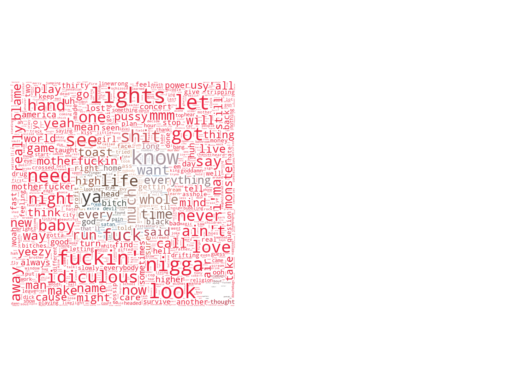

In [79]:
album_wordcloud('spotify:album:20r762YmB5HeofjMCiPMLv',False,1200,0.4)

Lemonade by Beyoncé


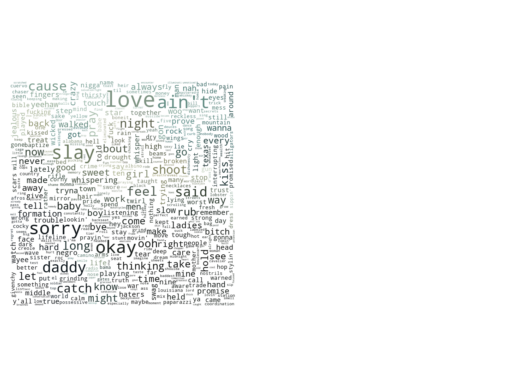

In [80]:
album_wordcloud('spotify:album:7dK54iZuOxXFarGhXwEXfF',False,1200,0.4)

Good Girl Gone Bad: Reloaded by Rihanna


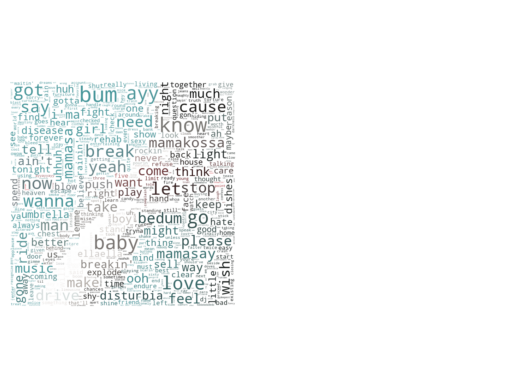

In [81]:
album_wordcloud('spotify:album:3JSWZWeTHF4HDGt5Eozdy7',False,1200,0.4)

Stadium Arcadium by Red Hot Chili Peppers


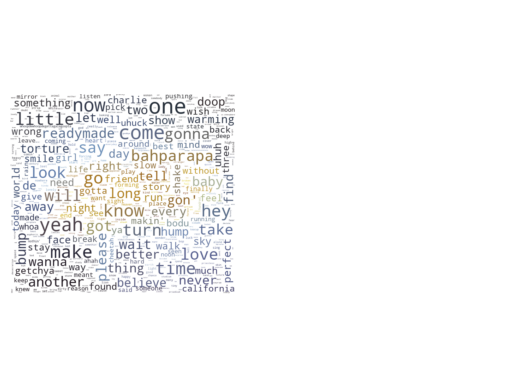

In [82]:
album_wordcloud('spotify:album:7xl50xr9NDkd3i2kBbzsNZ',False,1200,0.4)

Day & Age (Bonus Tracks) by The Killers


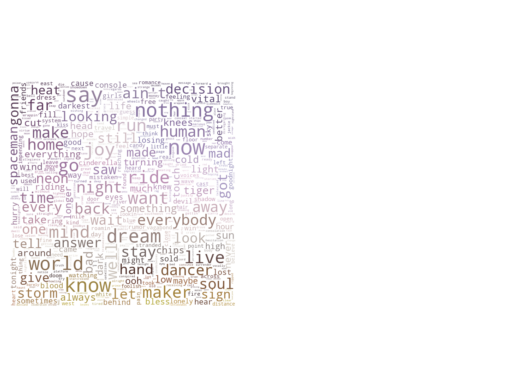

In [83]:
album_uri = 'spotify:album:0Ug5scDXUIgGN8yanDBLQw'
album_wordcloud(album_uri,False,1200,0.4)